In [1]:
import wave
import numpy as np
from scipy.ndimage import uniform_filter, maximum_filter
from IPython.display import display, Audio
import matplotlib.pyplot as plt
%matplotlib inline

## preparing implementation of STFT and ISTFT

In [2]:
def stft(x):
    window = np.hamming(1024)
    return np.array([np.fft.fft(window * x[i:i + 1024]) for i in range(0, len(x) - 1024 + 1, 256)]).T[0:1024 // 2 + 1]

In [3]:
def istft(X):
    window = np.hamming(1024)
    window_s = window ** 2
    X = np.concatenate((X, X[-2:0:-1].conj()), 0)
    _x = np.zeros(1024 + (X.shape[1] - 1) * 256)
    _s = np.zeros(1024 + (X.shape[1] - 1) * 256)
    for i in range(X.shape[1]):
        s = i * 256
        _x[s:s + 1024] += np.fft.ifft(X[:, i]).real * window
        _s[s:s + 1024] += window_s
    
    return _x / _s

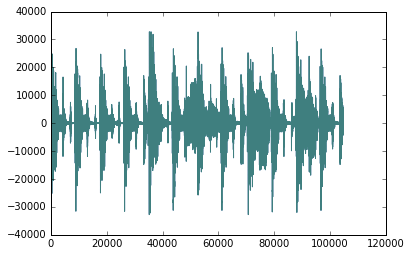

In [4]:
# test STFT and ISTFT

w = wave.open('../tests/fixture/drums+bass.wav')
x = np.fromstring(w.readframes(w.getnframes()), np.int16)

X = stft(x)
x_remixed = istft(X)

plt.plot(x, alpha=0.5)
display(Audio(x, rate=w.getframerate()))
plt.plot(x_remixed, alpha=0.5)
display(Audio(x_remixed, rate=w.getframerate()))

assert (np.isclose(x[:len(x_remixed)],
                                x_remixed)).all()

Next detect onsets.

ref: http://sv.mazurka.org.uk/MzSpectralFlux/

## getting spectral flux

In [5]:
pspec = np.abs(X) ** 2
diffs = pspec[:, 1:] - pspec[:, :-1]

# get each type of spectral fluxes
flux = np.mean(diffs, 0)
flux_pos = np.mean(np.maximum(0, diffs), 0)
flux_neg = np.mean(np.minimum(0, diffs), 0)
flux_dif = flux_pos - flux_neg

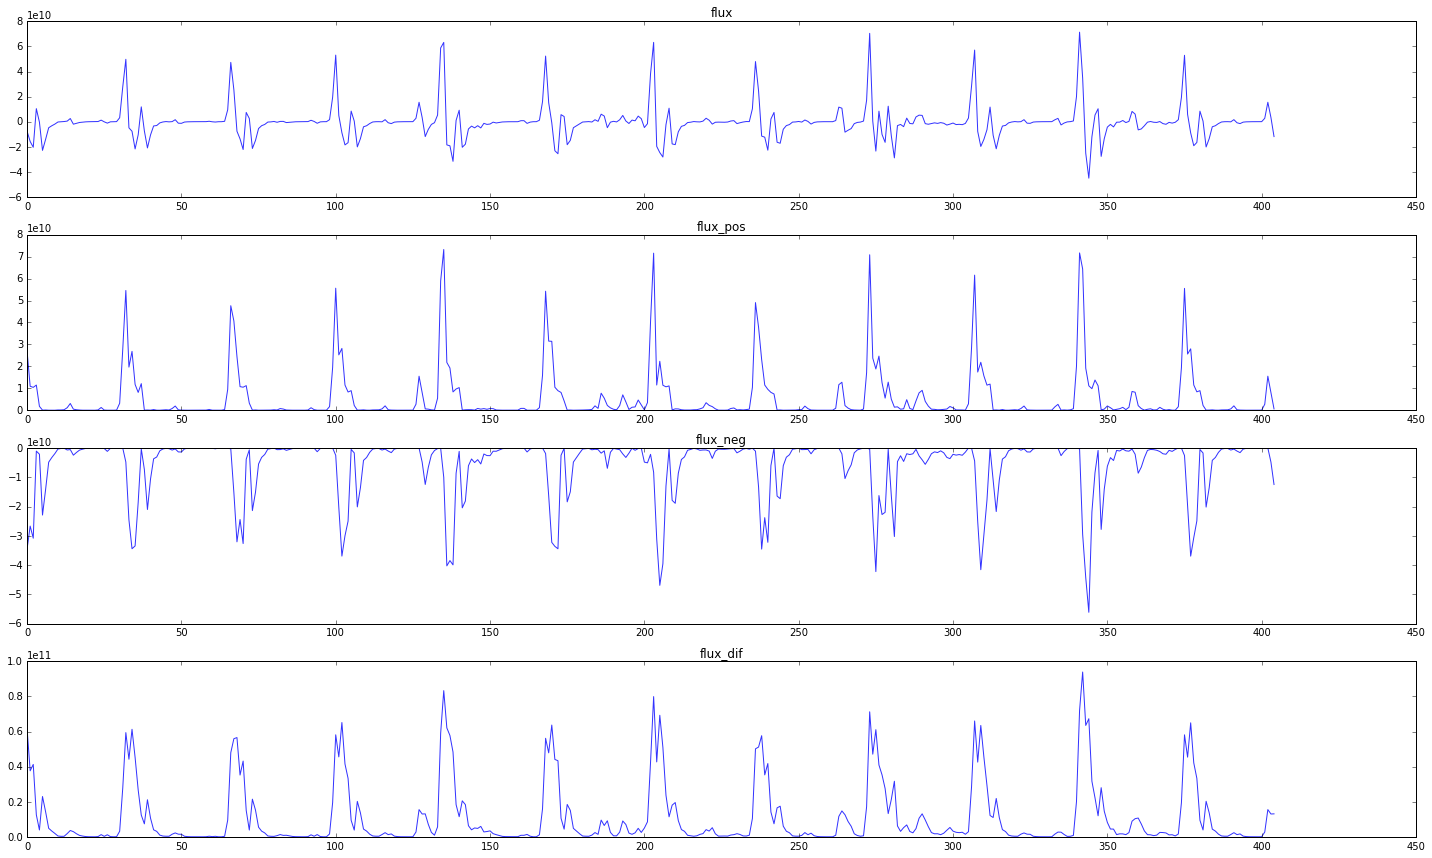

In [6]:
plt.figure(figsize=(20, 12))
for i, (f, l) in enumerate(zip([flux, flux_pos, flux_neg, flux_dif], ['flux', 'flux_pos', 'flux_neg', 'flux_dif'])):
    plt.subplot(4, 1,  i + 1)
    plt.plot(f, alpha=0.8)
    plt.title(l)

plt.tight_layout()

## getting each {local_mean, local_maximum, exponential_decay} thresholds

In [7]:
mspf = 256 / w.getframerate() * 1000
multiplier = 1.5
local_mean_time = 150  # ms
local_maximum_time = 60  #ms

local_mean = uniform_filter(flux_pos, local_mean_time // mspf)
local_mean_threshold = local_mean * multiplier
print('calculated local mean threslowithin {} ms'.format(local_mean_time))

local_maximum = maximum_filter(flux_pos, local_maximum_time // mspf)
print('calculated local maximum within {} ms'.format(local_maximum_time))

def gen_exponential_decay(x, fact, acc=np.array([0])):
    if len(x) == 0:
        return acc[1:]
    return gen_exponential_decay(x[1:], fact, np.append(acc, max(x[0], fact * acc[-1] + (1 - fact) * x[0])))

exponential_decay = gen_exponential_decay(flux_pos, 0.80)
print('calculated explonential decay')

calculated local mean threslowithin 150 ms
calculated local maximum within 60 ms
calculated explonential decay


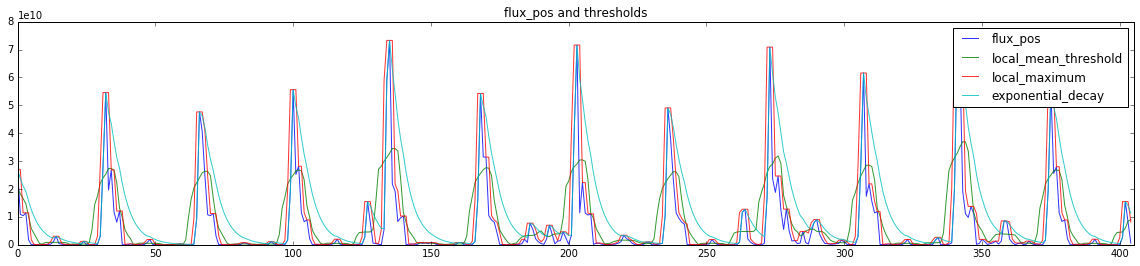

In [8]:
plt.figure(figsize=(20, 4))
plt.title('flux_pos and thresholds')
for i in (flux_pos, local_mean_threshold, local_maximum, exponential_decay):
    plt.plot(i, alpha=0.8)
plt.xlim(0, len(flux_pos))
plt.legend(['flux_pos', 'local_mean_threshold', 'local_maximum', 'exponential_decay'])

## Thresholding

onsets detected at [    0.   224.   384.   512.   944.  1056.  1472.  1600.  2032.  2160.
  2576.  2688.  2976.  3088.  3248.  3520.  3664.  3776.  4224.  4368.
  4640.  4912.  5344.  5456.  5728.  6000.  6432.] (ms)


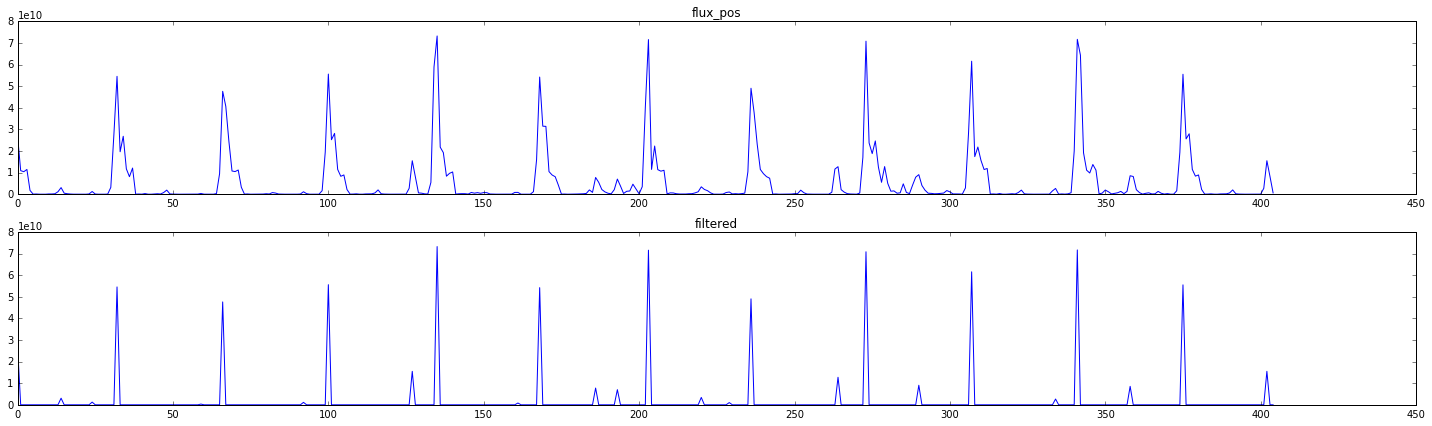

In [9]:
filtered = (flux_pos * 
            (flux_pos - local_mean_threshold >= 0) * 
            (flux_pos - local_maximum >= 0) * 
            (flux_pos - exponential_decay >= 0))

plt.figure(figsize=(20, 6))
plt.subplot(2, 1, 1)
plt.title('flux_pos')
plt.plot(flux_pos)
plt.subplot(2, 1, 2)
plt.title('filtered')
plt.plot(filtered)
plt.tight_layout()

print('onsets detected at {} (ms)'.format((np.array(np.where(filtered > 0)) * mspf)[0]))